In [39]:
import numpy as np
from numpy.linalg import inv, multi_dot
from numpy import matmul, exp, transpose, multiply
import pandas as pd
from matplotlib import pyplot as plt
from typing import List
from scipy.optimize import minimize

In [74]:
class timeSeries():
    def __init__(self, df: pd.DataFrame, countries: List[str], start: str, end: str):
        df.dateRep = pd.to_datetime(df.dateRep, format='%d/%m/%Y')
        self.start = start
        self.end = end
        self.rawData = df
        self.allCountries = df.countriesAndTerritories.unique()
        self.processedData = self.extract_countries_and_time(countries, start, end)


    def extract_countries_and_time(self, countries: List[str], start: str, end: str) -> pd.DataFrame:
        """
        Filters the data frame by the specified time frame and countries.
        Args:
            df_path (str): default = path
            countries (list<str>) 
            start (str): yyyy-mm-dd
            end (str): yyyy-mm-dd 
        """
        df = self.rawData
        df = df[["dateRep", "day", "month", "year", "cases", "countriesAndTerritories"]]
        df = df[df.countriesAndTerritories.isin(countries)]
        df = df.sort_values(["year", "month","day"])
        df["cumCases"] = df.groupby(["countriesAndTerritories"])["cases"].cumsum(axis=0)


        if (start == "start") & (end == "end"):
            output_df = df
        elif (start == "start"):
            output_df = df[df.dateRep <= end]
        elif (end == "end"):
            output_df = df[df.dateRep >= start]
        else:
            output_df = df[(start <= df.dateRep) & (df.dateRep <= end)]

        return output_df

    def plot(self) -> pd.DataFrame:
        """
        Plots the data for each country in the specified time frame 
        """
        df = self.processedData
        groups = df.groupby("countriesAndTerritories")

        fig, ax = plt.subplots(figsize = (10,5))
        ax.margins(0.05)

        for name, group in groups:
            ax.plot(group.dateRep, group.cumCases, label=name)

        ax.legend()
        plt.show()

    def extract_country(self, country: str):    
        """
        Exracts the data of a specific country for further calculations
        """
        df = self.processedData
        df = df.reset_index(drop = True)
        df = df[df.countriesAndTerritories == country]
        df["t"] = list(range(len(df)))
        df = df.reset_index(drop = True)
        return df[["dateRep", "t", "cumCases"]]

    def linear_regression(self, country_name: str):
        """
        Returns beta of the linear regression
        and plots the prediction vs real data
        """
        country = self.extract_country(country_name)
        M = len(country)
        I_0 = np.double(country.loc[country["t"] == 0, "cumCases"])
        t = np.array(country.loc[country["t"] > 0, "t"]).reshape(-1, 1)
        I = np.array(country.loc[country["t"] > 0, "cumCases"]).reshape(-1, 1)

        # Lineares Ausgleichsproblem
        X = t
        XT = t.transpose()
        y = np.log(I) - np.log(I_0)
        beta_hat = np.double(multi_dot([inv(matmul(XT, X)),XT,y])).round(4)
        prediction = I_0 * exp(beta_hat * t)
        

        fig, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)

        ax.set_title(f"{country_name}, {self.start} - {self.end}", fontsize = 18)
        ax.plot(country.t[1:],prediction, label="LAP", color="red",)
        ax.plot(country.t[1:],country.cumCases[1:], label="Real data", color="blue")
        ax.text(0.65, 0.8, f"$\hat \\beta = $ {str(beta_hat)}", transform=ax.transAxes, fontsize=18)
        plt.rc('legend',fontsize=16)

        ax.legend()
        plt.show() 
        return beta_hat
    
    def nonlinear_regression(self, country_name: str):
        """
        Returns the result for Newton's method
        and plots the prediction vs real data
        """
        country = self.extract_country(country_name)
        M = len(country)
        I_0 = np.double(country.loc[country["t"] == 0, "cumCases"])
        t = np.array(country.loc[country["t"] > 0, "t"]).reshape(-1, 1)
        I = np.array(country.loc[country["t"] > 0, "cumCases"]).reshape(-1, 1)

        # Newton's Method
        def G(x):
            return matmul(transpose(I - I_0*exp(x*t)), I - I_0*exp(x*t))

        # G'(x)
        def dGdx(x):
            return 2* I_0**2*np.sum(np.multiply(t,multiply(exp(x*t)-I/I_0,exp(x*t))))

        beta_star = float(minimize(G, x0=self.linear_regression(country_name), method="Newton-CG", jac=dGdx).x)
        prediction = I_0 * exp(beta_star * t)
        

        fig, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)

        ax.set_title(f"{country_name}, {self.start} - {self.end}", fontsize = 18)
        ax.plot(country.t[1:],prediction, label="Newton-Methode", color="red",)
        ax.plot(country.t[1:],country.cumCases[1:], label="Real data", color="blue")
        ax.text(0.65, 0.8, f"$ \\beta^* = $ {str(beta_star)}", transform=ax.transAxes, fontsize=18)
        plt.rc('legend',fontsize=16)

        ax.legend()
        plt.show()
        return beta_star
        

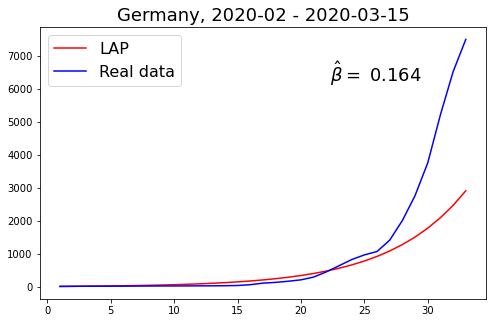

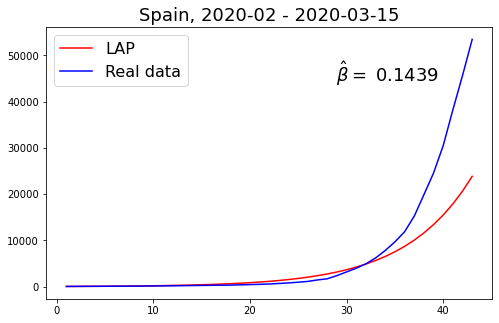

In [75]:
df = pd.read_csv("data/europe_timeseries.csv")
ts = timeSeries(df, ["Germany", "Spain"], "2020-02", "2020-03-15")
ts.linear_regression("Germany");
ts.linear_regression("Spain");

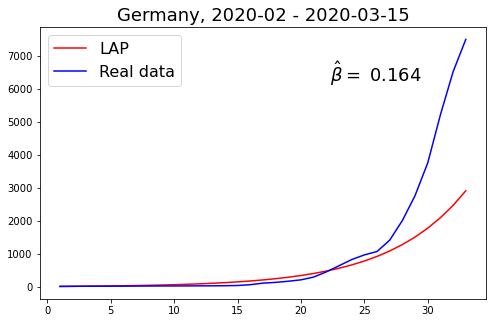

<ipython-input-74-d7fbab8b674c>:114: RuntimeWarning: overflow encountered in exp
  return 2* I_0**2*np.sum(np.multiply(t,multiply(exp(x*t)-I/I_0,exp(x*t))))
<ipython-input-74-d7fbab8b674c>:114: RuntimeWarning: overflow encountered in multiply
  return 2* I_0**2*np.sum(np.multiply(t,multiply(exp(x*t)-I/I_0,exp(x*t))))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1799: RuntimeWarning: invalid value encountered in multiply
  ri = ri + alphai * Ap


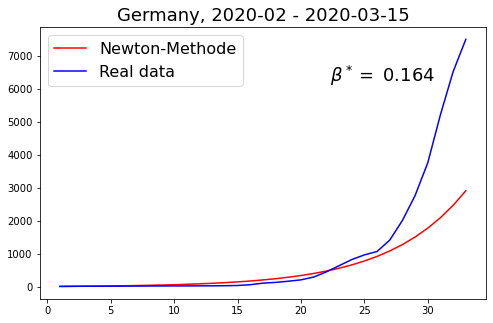

0.164

In [76]:
ts.nonlinear_regression("Germany")

In [67]:
np.linspace(3,3,3)

array([3., 3., 3.])